# Fig.4b Correlations among models

In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
sns.set_style()
import pandas as pd

In [2]:
sys.path.append(os.path.join(os.getcwd(),'../repos/dysts/'))
sys.path.append(os.path.join(os.getcwd(),'../repos/darts/'))

In [3]:
import darts

In [4]:
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

loaded!


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Forecasting Benchmark Results

In [6]:
import os
import json

GRANULARITY = 100
DATE = 221025 # noise level 0.8, not including RBF
#DATE = 220812 # noise level 0.2, not including RBF

#/results/221025_results_test_univariate__pts_per_period_ # large noise 
#/results/220812_results_test_univariate__pts_per_period_ # small noise 

#220315_results_test_univariate__pts_per_period_ #Initial try
#220326_results_test_univariate__pts_per_period_
#/results/220426_results_test_univariate__pts_per_period_

with open(
    os.getcwd()
    + "/../repos/dysts/benchmarks/results/" + str(DATE) + "_results_test_univariate__pts_per_period_" + str(GRANULARITY) 
    + "__periods_12_noise.json",
    "r",
) as file:
    all_results = json.load(file)

#220428
# with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_15__periods_12_noise.json", "r") as file:
#     all_results = json.load(file)



## Convert R2 into a distance
all_r2 = list()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue            
        else:
            ## convert r2 to a pseudodistance
            all_results[equation_name][model_name]["r2_score"] = (
                1 - all_results[equation_name][model_name]["r2_score"]
            )

            ## Coefficient of variation must be normed
            all_results[equation_name][model_name]["coefficient_of_variation"] = np.abs(
                all_results[equation_name][model_name]["coefficient_of_variation"]
            )

            ## Drop RMSE because it overlaps with MSE
            all_results[equation_name][model_name].pop("rmse", None)

# HS Remove unimportant methods
for equation_name in all_results:
    for model_name in ['FFT', 'FourTheta', 'AutoARIMA', 'LSS_Takens']:
        #all_results[equation_name].pop(model_name, None)
        del all_results[equation_name][model_name]

# HS using local darts
#sys.path.append(os.path.join(os.getcwd(),'../../darts/'))
import darts
from darts import TimeSeries
from darts.metrics import mae

wrap_array = lambda x: TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(np.array(x))))
mae_func = lambda x, y: mae(wrap_array(x), wrap_array(y))


## Calculate MASE
for equation_name in all_results:
    baseline_onestep = mae_func(
        all_results[equation_name]["values"][1:],
        all_results[equation_name]["values"][:-1],
    )
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            mae_val = all_results[equation_name][model_name]["mae"]
            all_results[equation_name][model_name]["mase"] = mae_val / baseline_onestep

## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])

all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][
            model_name
        ]


hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])

    hist_values[model_name] = smape_vals.copy()

if GRANULARITY == 15:
    hist_values_low = hist_values.copy()
elif GRANULARITY == 100:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")
    

    #/results/221025_results_test_univariate__pts_per_period_
#/results/220812_results_test_univariate__pts_per_period_ # small noise 

if DATE == 220812:
    hist_values_low = hist_values.copy()
elif DATE == 221025:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")


all_metric_names = list(all_results_transposed["ARIMA"]["Aizawa"].keys())
all_metric_names.remove("prediction")

## Compute forecast metrics
metric_records = dict()
for metric_name in all_metric_names:
    metric_records[metric_name] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        for metric_name in all_metric_names:
            metric_records[metric_name].append(
                all_results_transposed[model_name][equation_name][metric_name]
            )
df_metrics = pd.DataFrame(metric_records)


# df_metrics["coefficient_of_variation"] = np.abs(df_metrics["coefficient_of_variation"])
# df_metrics = df_metrics.drop('rmse', 1)

In [7]:
df_metrics.shape

(1792, 8)

### Load mathematical properties

In [8]:
import dysts.flows

max_lyap = list()
best_scores = list()
for equation_name in all_results:    
    all_scores_per_equation = list()
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_scores_per_equation.append(all_results[equation_name][model_name]["smape"])
    
    best_scores.append(min(all_scores_per_equation))

    eq = getattr(dysts.flows, equation_name)()
    max_lyap.append(eq.maximum_lyapunov_estimated)
        


### Correlate forecasting models

In [9]:
model_records = dict()
for model_name in all_results_transposed.keys():
    model_records[model_name] = list()
    
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        model_records[model_name].append(all_results_transposed[model_name][equation_name]["smape"])    
    
df_models = pd.DataFrame(model_records)

corr_array = np.array(df_models.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

df_models_sorted = df_models.iloc[:, np.argsort(np.nanmedian(corr_array, axis=0))[::-1]]
df_models_sorted = df_models.iloc[:, np.argsort(np.nanmax(corr_array, axis=0))[::-1]]

# ax = sns.heatmap(df_models_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
# ax.set_aspect('equal')
# ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/model_correlation_map.png", dpi=600)

### Compare forecasting metrics

In [10]:

corr_array = np.array(df_metrics.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

metric_sort_inds = np.argsort(np.nanmedian(corr_array, axis=0))[::-1]
metric_sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
df_metrics_sorted = df_metrics.iloc[:, metric_sort_inds]

## Figure

In [17]:
df_models_sorted.columns

Index(['NaiveSeasonal', 'NaiveDrift', 'ARIMA', 'Theta', 'NaiveMean',
       'LinearRegressionModel', 'KalmanForecaster', 'ExponentialSmoothing',
       'NLSS_Takens', 'RandomForest', 'TransformerModel', 'NBEATSModel',
       'RNNModel', 'TCNModel'],
      dtype='object')

In [18]:
df_models_sorted=df_models_sorted.rename(columns = {'NLSS_Takens':'PNL-SS', 'LinearRegressionModel': 'LinearRegression', 'ExponentialSmoothing' : 'ExpSmoothing', 'TransformerModel': 'Transformer', 'NBEATSModel' : 'NBEATS', 'RNNModel' : 'RNN', 'TCNModel': 'TCN' })

In [19]:
order_high=['PNL-SS', 'NBEATS', 'Transformer', 'TCN',
       'RNN', 'RandomForest', 'Theta', 'ARIMA', 'NaiveSeasonal',
       'NaiveDrift', 'LinearRegression', 'ExpSmoothing',
       'NaiveMean', 'KalmanForecaster']

In [20]:
df_models_sorted = df_models_sorted.reindex(columns=order_high)
df_models_sorted = df_models_sorted[df_models_sorted.columns[::-1]]

In [21]:

corr_matrix=df_models_sorted.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

In [22]:
corr_matrix

,KalmanForecaster,NaiveMean,ExpSmoothing,LinearRegression,NaiveDrift,NaiveSeasonal,ARIMA,Theta,RandomForest,RNN,TCN,Transformer,NBEATS,PNL-SS
KalmanForecaster,1.000000,0.409197,0.572554,0.540520,0.509362,0.545213,0.806331,0.831098,0.659437,0.566489,0.616279,0.614345,0.454518,0.508898
NaiveMean,0.409197,1.000000,0.295596,0.881953,0.405083,0.405346,0.380625,0.404384,0.430633,0.591186,0.589206,0.506283,0.594288,0.667048
ExpSmoothing,0.572554,0.295596,1.000000,0.303138,0.568898,0.576268,0.756272,0.769073,0.579358,0.419692,0.433546,0.525030,0.254383,0.283631
LinearRegression,0.540520,0.881953,0.303138,1.000000,0.439159,0.460659,0.448390,0.474055,0.505602,0.655941,0.659775,0.578780,0.682213,0.769050
NaiveDrift,0.509362,0.405083,0.568898,0.439159,1.000000,0.970564,0.680318,0.664582,0.682487,0.500670,0.523044,0.554969,0.456487,0.492492
NaiveSeasonal,0.545213,0.405346,0.576268,0.460659,0.970564,1.000000,0.717846,0.703895,0.686109,0.525219,0.534838,0.569876,0.453277,0.506981
ARIMA,0.806331,0.380625,0.756272,0.448390,0.680318,0.717846,1.000000,0.968910,0.745594,0.571089,0.600062,0.658636,0.392030,0.437288
Theta,0.831098,0.404384,0.769073,0.474055,0.664582,0.703895,0.968910,1.000000,0.738876,0.583232,0.592760,0.674522,0.407183,0.458450
RandomForest,0.659437,0.430633,0.579358,0.505602,0.682487,0.686109,0.745594,0.738876,1.000000,0.634688,0.656010,0.717823,0.535679,0.517184
RNN,0.566489,0.591186,0.419692,0.655941,0.500670,0.525219,0.571089,0.583232,0.634688,1.000000,0.695179,0.587524,0.547284,0.682321


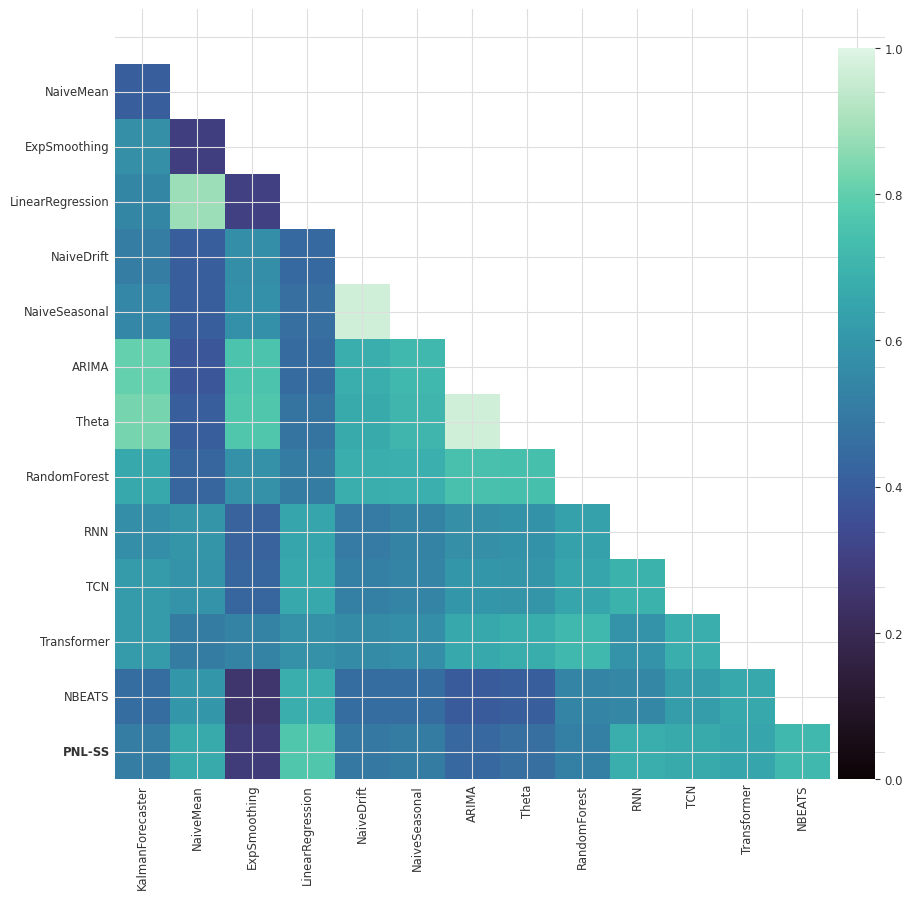

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap="mako", vmin=0, vmax=1, mask=mask, ax=ax,cbar_kws={"shrink": 0.95, "location": "right", "pad": -0.04000,"anchor":(0, 0)})
#im = ax.get_children()[0]
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)
ax.get_yticklabels()[13].set_weight('bold')
ax.get_yticklabels()[0].set_visible(False)
ax.get_xticklabels()[13].set_visible(False)
#plt.savefig('for_cor.eps', format='eps', dpi=500, bbox_inches='tight')
#plt.savefig('fig/for_cor_PNL_SS.jpg', format='jpg', dpi=1000, bbox_inches='tight')
plt.show()